<a href="https://colab.research.google.com/github/libbyrose/ceos-db-toolkit/blob/main/Custom_Timelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

<i>This notebook creates a custom timeline image
    
(1) Launch Date and EOL Range (min-max)

AND

(2) CustomTimelineID

* The query prints a timeline of the missions that meet the specified criteria    
    
(Gantt chart adapted from: https://sukhbinder.wordpress.com/2016/05/10/quick-gantt-chart-with-matplotlib/)</i>

In [ ]:
# Import API-related modules
import requests
import json

# Import for Quick Gantt Chart with Matplotlib example.
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager
import matplotlib.dates
from matplotlib.dates import WEEKLY,MONTHLY,YEARLY, DateFormatter, rrulewrapper, RRuleLocator 
import numpy as np

# Import to sort mission dates.
from operator import itemgetter, attrgetter

#Import for date conversion.
from dateutil import parser
import datetime
import time

#Import for SQL tables
import pandas as pd
from pandas import DataFrame


## Connect to Google Drive and the database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specify the path to yml file contating database access information

In [ ]:
# Specify the path in your local drive (use !ls and !pwd to hunt for it)
#Libby path: 
config_path='/content/drive/MyDrive/MIM Colab/config-libby.yml'
#George path:config_path='/content/drive/MyDrive/Colab-MIM Notebooks/config.yml'
print('Getting CEOS Dev DB Config from: ' + config_path)

Getting CEOS Dev DB Config from: /content/drive/MyDrive/MIM Colab/config-libby.yml


#### Save access information

In [ ]:
# Define SECRET database connection variables (MIM Dev DB on AWS RDS)
# Like YAML here: https://veekaybee.github.io/2020/02/25/secrets/
import yaml

with open(config_path, 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

user = cfg['ceos_dev_db']['user']
password = cfg['ceos_dev_db']['password']
database = cfg['ceos_dev_db']['database']
server = cfg['ceos_dev_db']['server']

#### Install DB Access Layer

A few code blocks to setup the necessary software to access the CEOS DB.

Define basic functions to access CEOS DB.

In [ ]:
# CHECK YOUR ODC COLAB VIRTUAL MACHINE IP ADDRESS
# The CEOS Dev DB is protected by whitelisting due to lots of attempts to query it
# Whitelisting means you can only connect from certain IP addresses

# Used this command to find the IP address of the Colab notebook (VM)
!curl ifconfig.me

# THE FOLLOWING RANGES HAVE BEEN WHITELISTED TO CONNECT TO THE AWS DATABASE
# 34.xxx.xxx.xxx
# 35.xxx.xxx.xxx
# 104.xxx.xxx.xxx

# IF YOUR VM IP IS NOT IN THIS RANGE* THEN IT WILL HAVE TO BE ADDED TO THE WHITELIST BEFORE IT WILL WORK (CONTACT GEORGE)
# * As a work around, you could start a new Colab notebook (VM) to see if you can get an IP address in the whitelist range.

34.121.194.59

In [ ]:
# Run this block to install the necessary DB interface code

%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list

sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

OK
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://packages.microsoft.com/ubuntu/16.04/prod xenial InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Err:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Release
  404  Not Found [IP: 65.8.48.97 443]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key output should not be parsed (stdout is not a terminal)
100   983  100   983    0     0   3425      0 --:--:-- --:--:-- --:--:--  3425
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    79  100    79    0     0    500      0 --:--:-- --:--:-- --:--:--   503
E: The repository 'https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Release' no longer has a Release file.


In [ ]:
# Run this block to install the Python library to connect to the DB
!pip install pyodbc

In [ ]:
# This this block to import the 'pyodbc' library
# pyodbc is used to connect Python (notebook) to the CEOS DB
# This import statment is how we include it when we're working on a local server
import pyodbc

In [ ]:
# Function to get DB cursor return
def get_db_cursor(user, password, database, server, t_sql):
  conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = server,
                      DATABASE = database,
                      UID = user,
                      PWD = password)

  db_cursor = conn.cursor()
  db_cursor.execute(t_sql)

  return db_cursor

In [ ]:
# Function that creates date variable.
def _create_date(datetxt):
    """Creates the date"""
    day,month,year=datetxt.split('-')
    date = dt.datetime(int(year), int(month), int(day))
    mdate = matplotlib.dates.date2num(date) 
    return mdate

## Select required filters



In [ ]:
#@title Define launch and EOL date ranges

launch_date_from = "1990-07-16" #@param {type:"date"}
launch_date_to = "2030-07-31" #@param {type:"date"}
# Launch date window (Y,M,D)
launch_date_start = datetime.datetime(int(launch_date_from.split('-')[0]),int(launch_date_from.split('-')[1]),int(launch_date_from.split('-')[2]))
launch_date_end = datetime.datetime(int(launch_date_to.split('-')[0]),int(launch_date_to.split('-')[1]),int(launch_date_to.split('-')[2]))

tsql_launchdate = """ Missions.launchDate > """ + "\'" + str(launch_date_start) + "\'" + """ 
    AND Missions.launchDate < """ + "\'" + str(launch_date_end) + "\'"

# EOL date window (Y,M,D)

EOL_date_from = "1900-07-30" #@param {type:"date"}
EOL_date_to = "2100-07-30" #@param {type:"date"}

eol_date_start = datetime.datetime(int(EOL_date_from.split('-')[0]),int(EOL_date_from.split('-')[1]),int(EOL_date_from.split('-')[2]))
eol_date_end = datetime.datetime(int(EOL_date_to.split('-')[0]),int(EOL_date_to.split('-')[1]),int(EOL_date_to.split('-')[2]))

tsql_eoldate = """Missions.eolDate > """ + "\'" + str(eol_date_start) + "\'" + """
    AND Missions.eolDate < """ + "\'" + str(eol_date_end) + "\'"

# start of query string
select = 'Missions.missionID, Missions.missionStatusID, Missions.launchDate, Missions.eolDate, Missions.missionNameShort'
tables = 'Missions'
conditions = '(' + tsql_launchdate + """
    AND """ + tsql_eoldate 

In [ ]:
#@title Filter out cancelled missions (or other specific statuses)
#@markdown List of statuses and IDs: https://docs.google.com/spreadsheets/d/13RSSiCP43_GgQl8LKeSn1jZ7yUSXiLQAgtieWKxlnLc/edit#gid=0&range=A1 
filter_by_status = True #@param ["True", "False"] {type:"raw"}
exclude_status_id = 5 #@param {type:"raw"}

if filter_by_status:
  if len(str(exclude_status_id).split(',')) == 1:
    tsql_status = "(NOT (Missions.missionStatusID IN (" + str(exclude_status_id) + ") ))"
  else:
    tsql_status = "(NOT (Missions.missionStatusID IN " + str(exclude_status_id) + " ))"
    
  conditions =  conditions + """
    AND """ + tsql_status

In [ ]:
#@title Custom Timeline ID 
#@markdown 20=Public GHG Missions, 21=Private GHG Missions
filter_by_custom_timeline = True #@param ["True", "False"] {type:"raw"}
custom_timeline_ID =  20#@param {type:"integer"}

if filter_by_custom_timeline:
  tsql_custom_timeline = 'CustomTimelines.customTimelineID = ' + str(custom_timeline_ID)
  conditions = conditions + """
    AND """ + tsql_custom_timeline +')'

  tables = tables + ''' INNER JOIN
         CustomTimelineMissions ON Missions.missionID = CustomTimelineMissions.missionID LEFT OUTER JOIN
         Instruments ON CustomTimelineMissions.instrumentID5 = Instruments.instrumentID LEFT OUTER JOIN
         Instruments AS Instruments_4 ON CustomTimelineMissions.instrumentID4 = Instruments_4.instrumentID LEFT OUTER JOIN
         Instruments AS Instruments_3 ON CustomTimelineMissions.instrumentID3 = Instruments_3.instrumentID LEFT OUTER JOIN
         Instruments AS Instruments_1 ON CustomTimelineMissions.instrumentID2 = Instruments_1.instrumentID LEFT OUTER JOIN
         Instruments AS Instruments_2 ON CustomTimelineMissions.instrumentID1 = Instruments_2.instrumentID LEFT OUTER JOIN
         CustomTimelines ON CustomTimelineMissions.customTimelineID = CustomTimelines.customTimelineID'''
  select = select + ''', CustomTimelines.customTimelineID, CustomTimelines.timelineName, 
           ISNULL(CustomTimelineMissions.customName, Missions.missionNameShort) AS missionNameShort, 
           CustomTimelineMissions.instrumentID1, ISNULL(CustomTimelineMissions.instrument1CustomName, Instruments_2.instrumentNameShort) AS instrument1CustomName, 
           CustomTimelineMissions.instrumentID2, ISNULL(CustomTimelineMissions.instrument2CustomName, Instruments_1.instrumentNameShort) AS instrument2CustomName, 
           CustomTimelineMissions.instrumentID3, ISNULL(CustomTimelineMissions.instrument3CustomName, Instruments_3.instrumentNameShort) AS instrument3CustomName, 
           CustomTimelineMissions.instrumentID4, ISNULL(CustomTimelineMissions.instrument4CustomName, Instruments_4.instrumentNameShort) AS instrument4CustomName, 
           CustomTimelineMissions.instrumentID5, ISNULL(CustomTimelineMissions.instrument5CustomName, Instruments.instrumentNameShort) AS instrument5CustomName '''

In [ ]:
#@title Exclude specific missions
exclude_missions = True #@param ["True", "False"] {type:"raw"}
missionID_exclude = 678 #@param {type:"raw"}

if exclude_missions:
  if len(str(missionID_exclude).split(',')) == 1:
    tsql_missionexclude = "(NOT (Missions.missionID IN (" + str(missionID_exclude) + ") ))"
  else:
    tsql_missionexclude = "(NOT (Missions.missionID IN " + str(missionID_exclude) + " ))"
  
  conditions = conditions + """
    AND """ + tsql_missionexclude

In [ ]:
#@title Include other missions
include_missions = False #@param ["True", "False"] {type:"raw"}
missionID_include = 4 #@param {type:"raw"}

if include_missions:
  if len(str(missionID_include).split(',')) == 1:
    tsql_missioninclude = "(Missions.missionID IN (" + str(missionID_include) + ") )"
  else:
    tsql_missioninclude = "(Missions.missionID IN " + str(missionID_include) + " )"
  
  conditions = conditions + """
    OR """ + tsql_missioninclude

## Execute Query Response

<i>Map the query response to the field types to generate the timeline plot.</i>

In [ ]:

# Execute
t_sql = 'SELECT ' + select + """
FROM """ +  tables + """
WHERE """ + conditions

print(t_sql)

db_cursor_return = get_db_cursor(user, password, database, server, t_sql) 

SELECT Missions.missionID, Missions.missionStatusID, Missions.launchDate, Missions.eolDate, Missions.missionNameShort, CustomTimelines.customTimelineID, CustomTimelines.timelineName, 
           ISNULL(CustomTimelineMissions.customName, Missions.missionNameShort) AS missionNameShort, 
           CustomTimelineMissions.instrumentID1, ISNULL(CustomTimelineMissions.instrument1CustomName, Instruments_2.instrumentNameShort) AS instrument1CustomName, 
           CustomTimelineMissions.instrumentID2, ISNULL(CustomTimelineMissions.instrument2CustomName, Instruments_1.instrumentNameShort) AS instrument2CustomName, 
           CustomTimelineMissions.instrumentID3, ISNULL(CustomTimelineMissions.instrument3CustomName, Instruments_3.instrumentNameShort) AS instrument3CustomName, 
           CustomTimelineMissions.instrumentID4, ISNULL(CustomTimelineMissions.instrument4CustomName, Instruments_4.instrumentNameShort) AS instrument4CustomName, 
           CustomTimelineMissions.instrumentID5, ISNULL(Cu

<i> Execute the SQL database query based on the chosen filters

In [ ]:
# Add mission names to ylables, mission dates to customDates.

mission_info = []
instrument_names = []


# Interate over DB response rows (missions) and extract needed values.
# Noting brittle (bad practice!) of row indicies (e.g. row[5]) - could use a better solution here
for row in db_cursor_return:
    mission_ID = row[0]
    mission_status = row[1]
    launchDate = parser.parse(str(row[2]))
    eolDate = parser.parse(str(row[3]))

    missionNameShort = str(row[4])


    timelineid = row[5]
    if filter_by_custom_timeline:
      if timelineid == custom_timeline_ID:
        timeline_name = str(row[6])


    mission_info.append([missionNameShort, launchDate, eolDate, mission_status, mission_ID])     

    instruments = []
    if row[8] != None:
      instruments.append(str(row[9]))
      if row[10] != None:
          instruments.append(str(row[11]))
          if row[12] != None:
              instruments.append(str(row[13]))
              if row[14] != None:
                  instruments.append(str(row[15]))
                  if row[16] != None:
                     instruments.append(str(row[17]))
 

    instrument_names.append([launchDate, instruments])
      

In [ ]:
# Close the DB cursor
db_cursor_return.close()

In [ ]:
# Sort mission info by launch date
missions_sorted = sorted(mission_info, key=itemgetter(1))
instrument_names_sorted = sorted(instrument_names, key=itemgetter(0))

## Create GanttChart

<i> Define a function for chart colours

In [ ]:
def colour_status(status):

    # based off colours from database.eohandbook.com
    current = '#1b2490' # dark blue
    approved = '#717ce1' # light blue
    planned = '#006400' # dark green
    considered = '#72ae64' # light green

    colours = ['white',       # 0 default
               current,       # 1 operational (nominal)
               approved,      # 2 approved
               planned,       # 3 planned
               considered,    # 4 considered
               'red',         # 5 cancelled
               'white',       # 6 default
               'white',       # 7 default
               'white',       # 8 default
               'white',       # 9 default
               'grey',        # 10 N/A
               'tomato',      # 11 mission complete
               considered,    # 12 commissioning
               current,       # 13 operational (extended)
               ]    

    if status >= len(colours):
      status = 0

    colour = colours[status]
    return colour


<i> Create a title for the plot based on active filters

In [ ]:
title = ''

if filter_by_custom_timeline:
  title = title + timeline_name
print(title)      

Public GHG Missions


<i>Define a function that makes the GanttChart

In [ ]:
def CreateMissionChart(missions_sorted, save_as_fig, instrument_names_sorted, year_interval):
    """
        Create gantt charts with matplotlib
        Give mission lables and dates.
    """ 
    mission_names = [i[0] for i in missions_sorted] 
    customDates = [i[1:3] for i in missions_sorted]
    status = [i[3] for i in missions_sorted]

    instrument_names = [i[1] for i in instrument_names_sorted]

    ylabels = [i + ' ' + str(j) for i, j in zip(mission_names, instrument_names)]

    ilen=len(ylabels)
    pos = np.arange(0.5,ilen*0.5+0.5,0.5)

    size = (max(min(2*len(mission_names),30),10),0.8*len(mission_names))
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)

    #for i in range(1):
    for i in range(len(ylabels)):
         start_date,end_date = customDates[i]
         ax.barh((i*0.5)+0.5, (end_date - start_date).days, left=start_date, height=0.3, align='center', edgecolor='lightgreen', color=colour_status(status[i]), alpha = 0.8)       

    locsy, labelsy = plt.yticks(pos,ylabels)
    plt.setp(labelsy, fontsize = 14)
#    ax.axis('tight')
    ax.set_ylim(ymin = -0.1, ymax = ilen*0.5+0.5)
    ax.grid(color = 'g', linestyle = ':')
    ax.xaxis_date()
    rule = rrulewrapper(YEARLY, interval=year_interval)
    loc = RRuleLocator(rule)
    formatter = DateFormatter("%Y")
    #formatter = DateFormatter("'%y") # 'yy format
    #formatter = DateFormatter("%d-%b '%y")
    #formatter = DateFormatter("%d-%b")
  
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    labelsx = ax.get_xticklabels()
    plt.setp(labelsx, rotation=30, fontsize=10)
 
    #font = font_manager.FontProperties(size='small')
    #ax.legend(loc=1,prop=font)
 
    ax.invert_yaxis()
    #fig.autofmt_xdate()

    handles = [mpatches.Patch(color=colour_status(1), label='Current'), mpatches.Patch(color=colour_status(2), label='Approved'), mpatches.Patch(color=colour_status(3), label='Planned'), mpatches.Patch(color=colour_status(4), label='Considered'), mpatches.Patch(color=colour_status(10), label='N/A'), mpatches.Patch(color=colour_status(11), label='Complete')]
    plt.legend(handles=handles)
    plt.title(title, fontsize=20)

    if save_as_fig:
      filename = 'drive/MyDrive/CEOS Database Timeline: ' + title + '.jpg'
      plt.savefig(filename)

    plt.show()


    

## Chart Output

In [ ]:
#@markdown Choose whether to save as figure - find the figure in your Drive

save_as_fig = False #@param ["True", "False"] {type:"raw"}

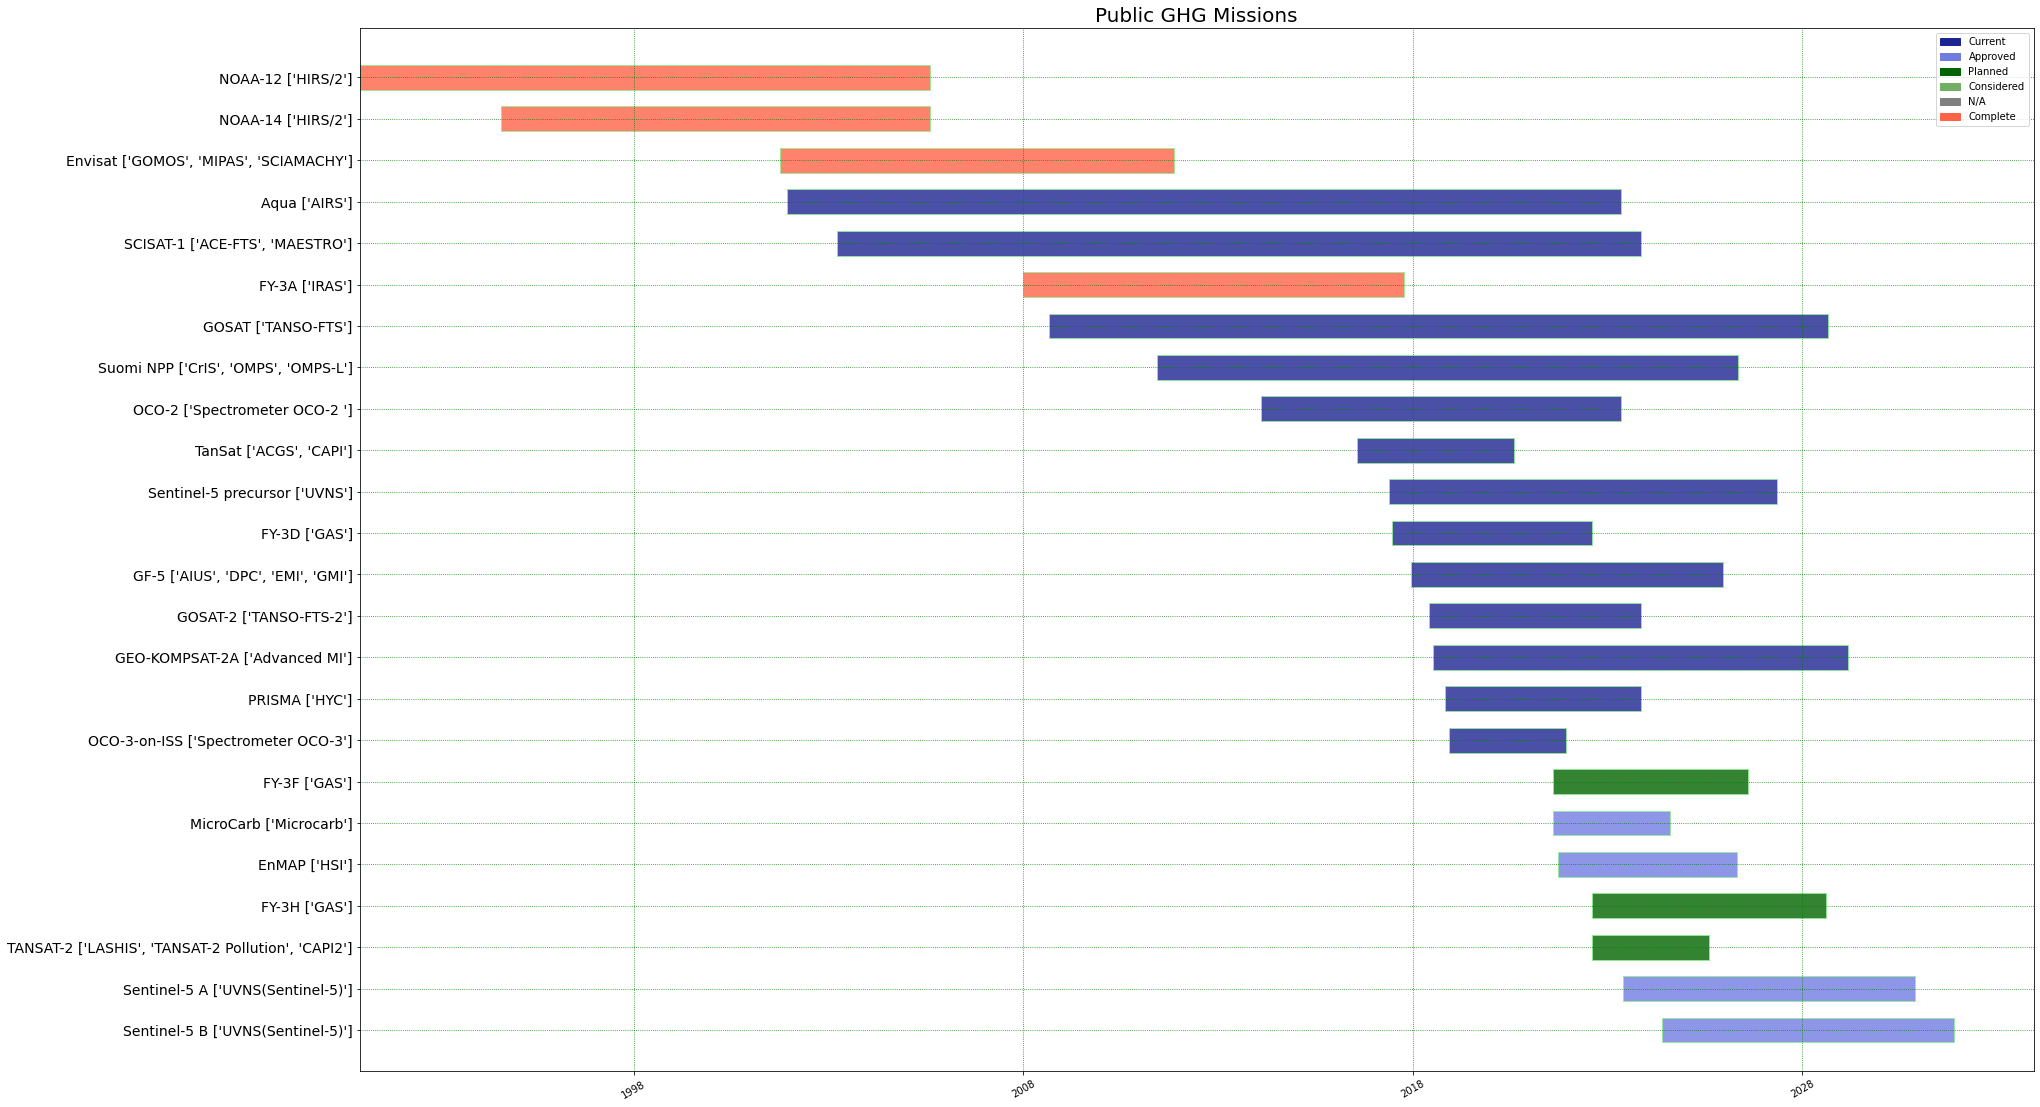

In [ ]:
CreateMissionChart(missions_sorted, save_as_fig, instrument_names_sorted, year_interval=10)

In [ ]:
#@title Export as spreadsheet
#@markdown Find the google sheet at https://sheets.google.com
export_as_spreadsheet = "False" #@param ["True", "False"]

if export_as_spreadsheet:

  # Save data as google sheets
  from google.colab import auth
  auth.authenticate_user()

  import gspread
  from oauth2client.client import GoogleCredentials

  gc = gspread.authorize(GoogleCredentials.get_application_default())


  mission_names = ['Mission Name Short'] + [i[0] for i in missions_sorted] 
  launch_date = ['Launch Date'] + [i[1] for i in missions_sorted]
  eol_date = ['EOL Date'] + [i[2] for i in missions_sorted]
  status = ['Mission Status'] + [i[3] for i in missions_sorted]
  mission_id = ['Mission ID'] + [i[4] for i in missions_sorted]

  # Open our new sheet and add some data.
  sheet_title = 'CEOS Database Timelines: ' + title
  sh = gc.create(sheet_title)
  worksheet = gc.open(sheet_title).sheet1

  cell_list = worksheet.range('A1:A'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = mission_id[i]
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('B1:B'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = mission_names[i]
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('C1:C'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = str(launch_date[i])
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('D1:D'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = str(eol_date[i])
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('E1:E'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    cell_list[i].value = status[i]
  worksheet.update_cells(cell_list)

  cell_list = worksheet.range('F1:F'+str(len(mission_names)))
  for i in np.arange(len(cell_list)):
    if i == 0:
      cell_list[i].value = 'Link to Database'
    else:
      cell_list[i].value = r'http://database.eohandbook.com/database/missionsummary.aspx?missionID=' + str(mission_id[i])  
  worksheet.update_cells(cell_list)

  # Go to https://sheets.google.com to see your new spreadsheet.